In [1]:
%matplotlib inline
import pandas as pd
import librosa as lib
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import scipy

In [2]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, train_test_split, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [3]:
#importing project created functions, these can be found in model_prep folder in repo
from model_prep import Xy_prep_all, Xy_prep_silence, Xy_prep_music, cross_val_time, Xy_prep_participants, Xy_prep_random_50

In [4]:
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

C:\Users\bwils\anaconda3\envs\micromotion\lib\site-packages\distributed\node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 51929 instead
  warnings.warn(


(<Scheduler: "tcp://127.0.0.1:51932" processes: 3 cores: 6>,
 {0: <Nanny: tcp://127.0.0.1:51957, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:51951, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:51952, threads: 2>})

In [5]:
model_data = pd.read_pickle('DFs/model_data.pkl')

# RandomForest Search - Train 50 Particpants - Test Others

In [6]:
rf = RandomForestRegressor()
params = {'criterion':['mse', 'mae'], 'max_depth':[1, 3, 5, 7], 'max_leaf_nodes':[2, 4, 6, 10], 
          'min_samples_split':[.1, .2, .3, .4, .5, .6, .7, .8, .9], 'min_samples_leaf':[.1, .2, .3, .4, .5]}
rsearch = RandomizedSearchCV(estimator=rf, param_distributions = params, n_iter=1,
                             scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'], refit='neg_mean_absolute_percentage_error')
X_train, X_test, y_train, y_test, train_par, test_par, cols, cut_rows = Xy_prep_random_50(model_data, 'target_20')
with joblib.parallel_backend('dask'):
    rsearch.fit(X_train, y_train)
scores = {'PID':[], 'R^2':[], 'mae':[], 'mape':[]}
preds=pd.DataFrame()
for i in test_par:
    X = X_test[X_test['PID']==i].drop(columns=['PID']).to_numpy()
    y = y_test[y_test['PID']==i].drop(columns=['PID']).to_numpy()
    y_pred = rsearch.predict(X)
    scores['PID'].append(i)
    scores['mae'].append(mean_absolute_error(y, y_pred))
    preds[str(i) + 'pred'] = y_pred
    preds[str(i) + 'actual'] = y
    scores['R^2'].append(rsearch.score(X, y))
    scores['mape'].append(mean_absolute_percentage_error(y, y_pred))
scoresdf = pd.DataFrame(scores)

In [8]:
rsearch.best_params_

{'min_samples_split': 0.1,
 'min_samples_leaf': 0.5,
 'max_leaf_nodes': 6,
 'max_depth': 1,
 'criterion': 'mae'}

In [9]:
scoresdf.describe()

,PID,R^2,mae,mape
count,23.000000,23.000000,23.000000,23.000000
mean,36.913043,-0.211477,39.405980,0.211477
std,22.530612,0.090044,12.438418,0.090044
min,3.000000,-0.397925,19.446814,0.084103
25%,18.000000,-0.250329,30.249356,0.139801
50%,39.000000,-0.210138,39.720876,0.210138
75%,51.500000,-0.139801,44.436798,0.250329
max,73.000000,-0.084103,63.881174,0.397925


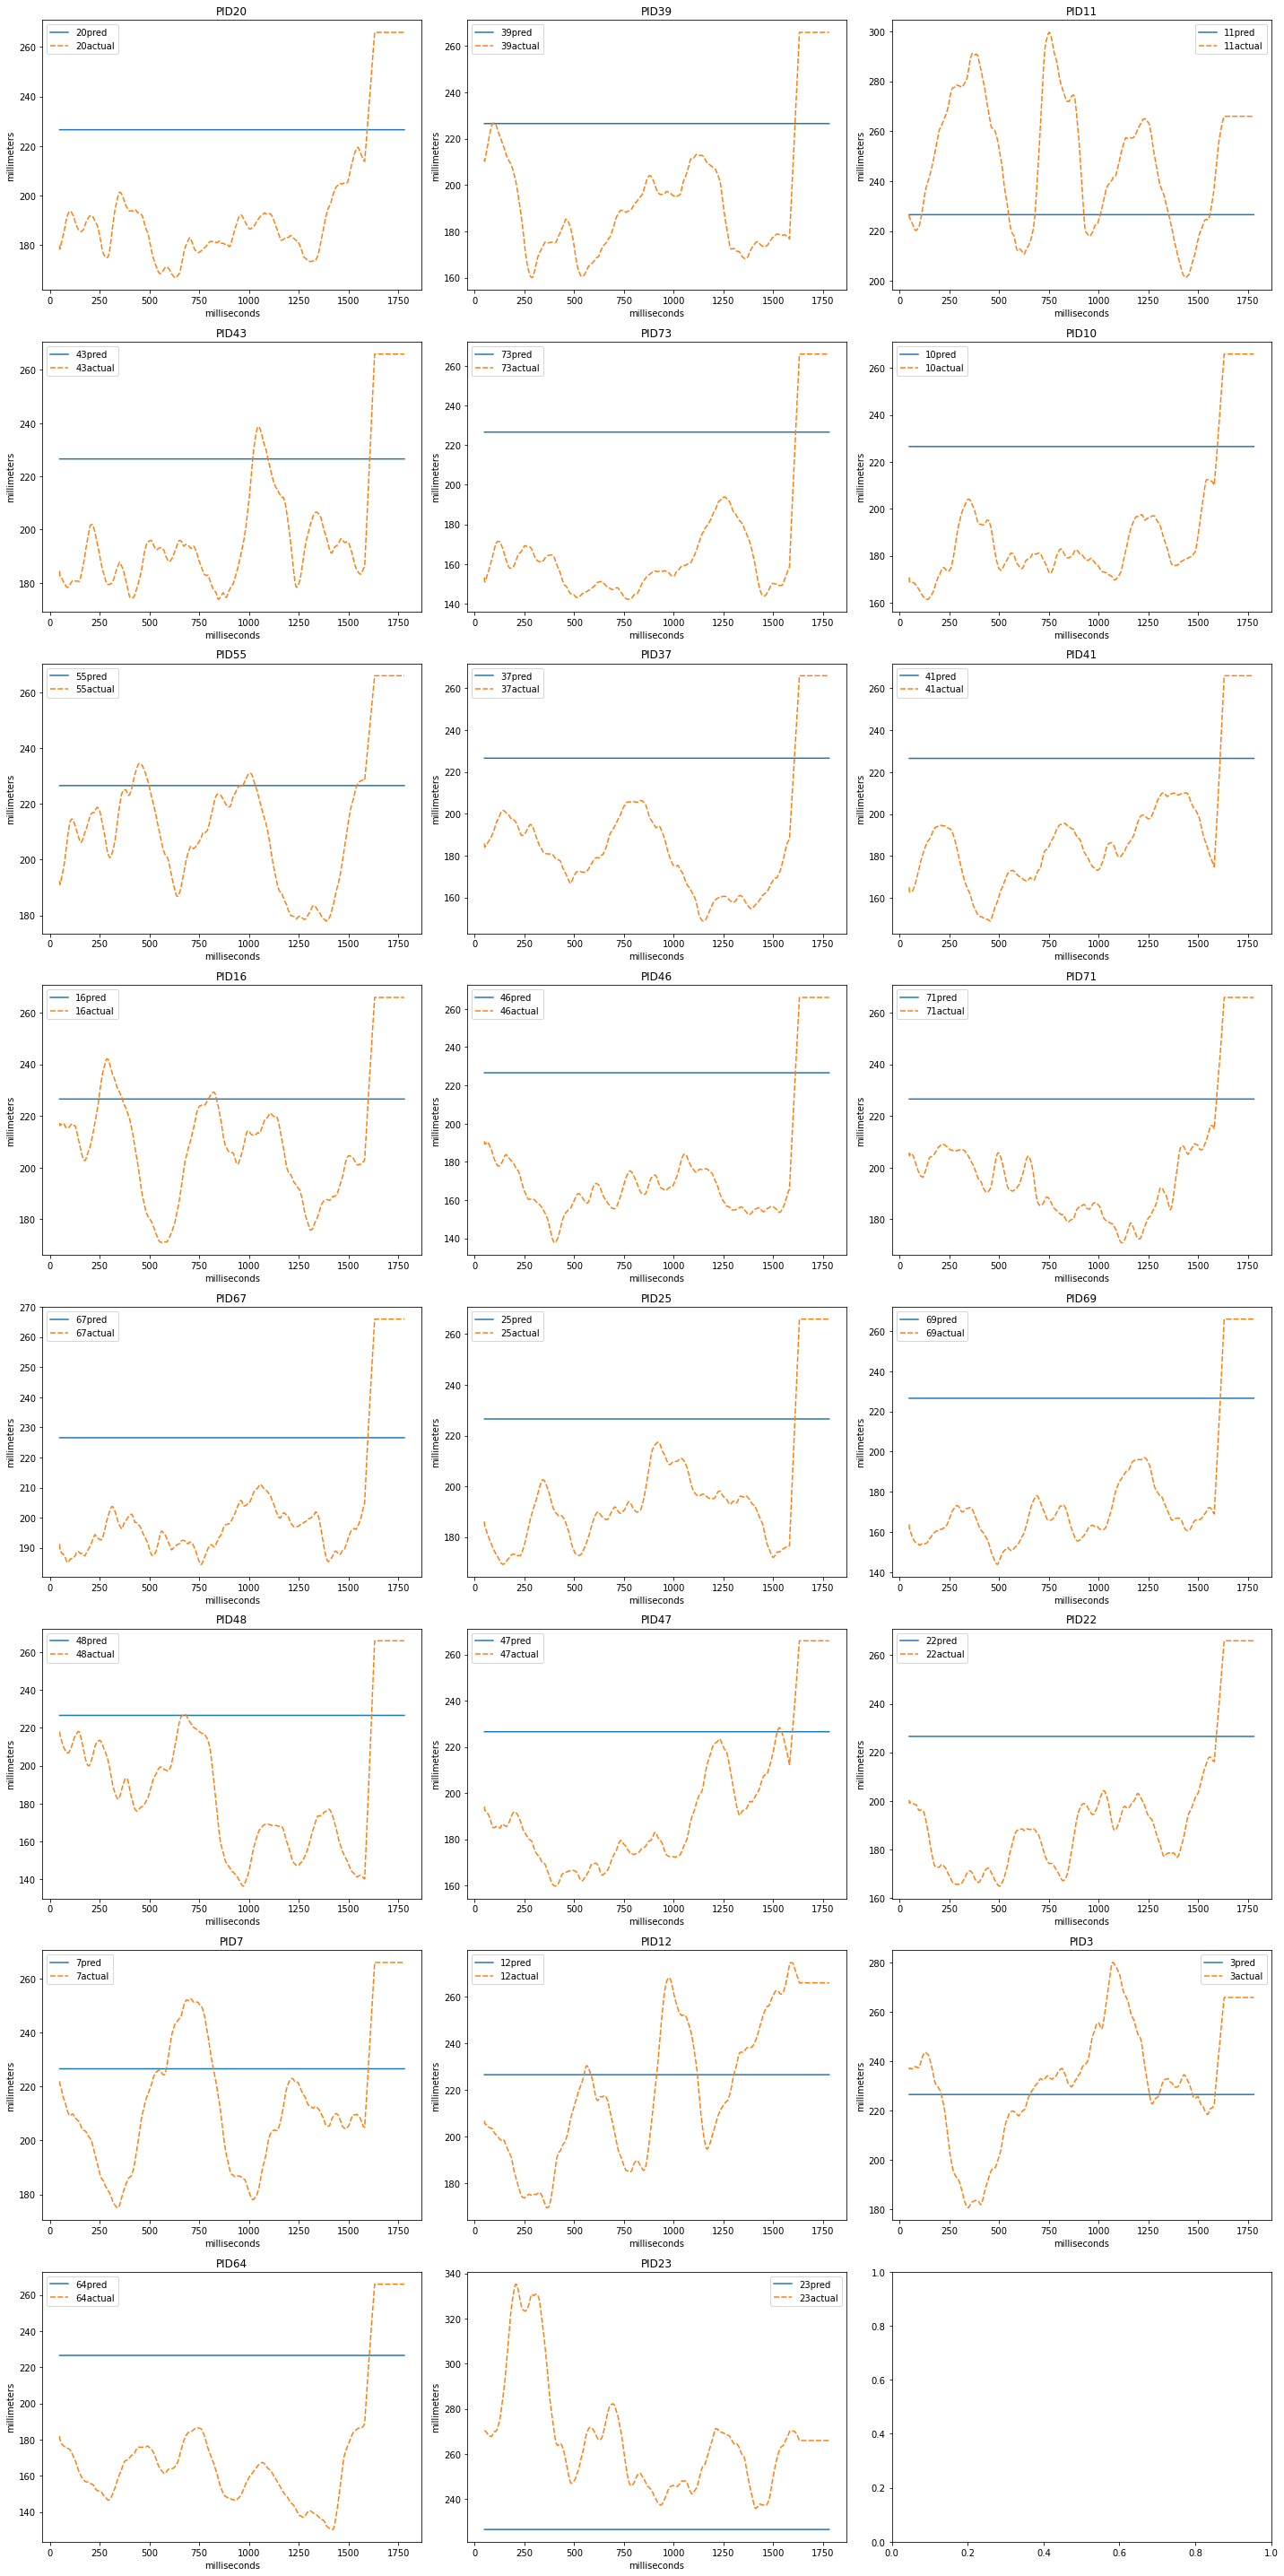

In [10]:
fig, axs = plt.subplots(8, 3, figsize=(20, 40))
for i, ax in zip(test_par, axs.flatten()):
    with joblib.parallel_backend('dask'):
        sns.lineplot(data=preds[[str(i)+'pred', str(i)+'actual']].rolling(50).mean(), ax=ax)
    ax.set_title('PID' + str(i))
    ax.set_ylabel('millimeters')
    ax.set_xlabel('milliseconds')
plt.tight_layout()
plt.show()

# ElasticNet Search - Train 50 Particpants - Test Others

In [11]:
elastic = ElasticNet()
params_elastic = {'alpha':[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1], 'l1_ratio':[.1, .2, .3, .4, .5, .6, .7, .8, .9]}
rsearch_elastic = RandomizedSearchCV(estimator=elastic, param_distributions = params_elastic, n_iter=20,
                             scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'], 
                                     refit='neg_mean_absolute_percentage_error')
X_train, X_test, y_train, y_test, train_par, test_par, cols, cut_rows = Xy_prep_random_50(model_data, 'target_20')
with joblib.parallel_backend('dask'):
    rsearch_elastic.fit(X_train, y_train)
scores = {'PID':[], 'R^2':[], 'mae':[], 'mape':[]}
preds=pd.DataFrame()
for i in test_par:
    X = X_test[X_test['PID']==i].drop(columns=['PID']).to_numpy()
    y = y_test[y_test['PID']==i].drop(columns=['PID']).to_numpy()
    y_pred = rsearch_elastic.predict(X)
    scores['PID'].append(i)
    scores['mae'].append(mean_absolute_error(y, y_pred))
    preds[str(i) + 'pred'] = y_pred
    preds[str(i) + 'actual'] = y
    scores['R^2'].append(rsearch_lastic.score(X, y))
    scores['mape'].append(mean_absolute_percentage_error(y, y_pred))
scoresdf = pd.DataFrame(scores)

KeyboardInterrupt: 

In [ ]:
rsearch_elastic.best_params_

In [ ]:
scoresdf.describe()

In [ ]:
fig, axs = plt.subplots(8, 3, figsize=(20, 40))
for i, ax in zip(test_par, axs.flatten()):
    with joblib.parallel_backend('dask'):
        sns.lineplot(data=preds[[str(i)+'pred', str(i)+'actual']].rolling(50).mean(), ax=ax)
    ax.set_title('PID' + str(i))
    ax.set_ylabel('millimeters')
    ax.set_xlabel('milliseconds')
plt.tight_layout()
plt.show()